In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('runs/fashion_cv_dropout_l1/dropout_p_0.0/fold5/activations_collected.csv')

df.shape


(8399, 64)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

# === 1. Cargar datos ===

df = pd.read_csv("runs/fashion_cv_dropout_l1/dropout_p_0.0/fold5/activations_collected.csv")
X = df.values


# === 2. Normalizar a norma L2 ===
X_norm = normalize(X, norm="l2")

# === 3. Definir criterio ===
# Dos vectores son "iguales" si dist < eps
eps = 0.5

# === 4. Calcular número de estados únicos ===
unique_states = []

for vec in X_norm:
    if len(unique_states) == 0:
        unique_states.append(vec)
        continue

    # distancias contra representantes actuales
    dists = np.linalg.norm(np.array(unique_states) - vec, axis=1)
    if np.min(dists) > eps:
        unique_states.append(vec)

num_unique_states = len(unique_states)

print("Epsilon usado:", eps)
print("Número de unique states:", num_unique_states)
print("Proporción sobre total:", num_unique_states, "/", len(X_norm))


Epsilon usado: 0.5
Número de unique states: 1202
Proporción sobre total: 1202 / 8399


Procesando 15 parámetros...


Parámetros:   0%|          | 0/15 [00:00<?, ?it/s]

  Procesando 5 folds para baseline...


    fold1: num_states=5730, train_acc=0.878, val_acc=0.865


    fold2: num_states=4896, train_acc=0.874, val_acc=0.848


    fold3: num_states=4956, train_acc=0.877, val_acc=0.842


    fold4: num_states=5967, train_acc=0.882, val_acc=0.860


Parámetros:   7%|▋         | 1/15 [01:29<20:53, 89.57s/it]

    fold5: num_states=5449, train_acc=0.872, val_acc=0.860
  Procesando 5 folds para dropout_p_0.0...


    fold1: num_states=5191, train_acc=0.879, val_acc=0.849


    fold2: num_states=6170, train_acc=0.880, val_acc=0.840


    fold3: num_states=5957, train_acc=0.877, val_acc=0.859


    fold4: num_states=5317, train_acc=0.872, val_acc=0.843


Parámetros:  13%|█▎        | 2/15 [03:19<22:01, 101.66s/it]

    fold5: num_states=5859, train_acc=0.879, val_acc=0.870
  Procesando 5 folds para dropout_p_0.2...


    fold1: num_states=5007, train_acc=0.823, val_acc=0.852


    fold2: num_states=5476, train_acc=0.838, val_acc=0.855


    fold3: num_states=4833, train_acc=0.828, val_acc=0.841


    fold4: num_states=4216, train_acc=0.826, val_acc=0.847


Parámetros:  20%|██        | 3/15 [04:55<19:49, 99.09s/it] 

    fold5: num_states=5251, train_acc=0.816, val_acc=0.852
  Procesando 5 folds para dropout_p_0.5...


    fold1: num_states=605, train_acc=0.461, val_acc=0.688


    fold2: num_states=1853, train_acc=0.612, val_acc=0.770


    fold3: num_states=704, train_acc=0.517, val_acc=0.694


    fold4: num_states=1812, train_acc=0.604, val_acc=0.776


Parámetros:  27%|██▋       | 4/15 [05:08<11:54, 64.92s/it]

    fold5: num_states=1520, train_acc=0.586, val_acc=0.759
  Procesando 5 folds para dropout_p_0.6...


    fold1: num_states=276, train_acc=0.345, val_acc=0.445


    fold2: num_states=170, train_acc=0.257, val_acc=0.343


    fold3: num_states=121, train_acc=0.272, val_acc=0.347


    fold4: num_states=68, train_acc=0.244, val_acc=0.399


Parámetros:  33%|███▎      | 5/15 [05:10<07:04, 42.47s/it]

    fold5: num_states=218, train_acc=0.330, val_acc=0.481
  Procesando 5 folds para dropout_p_0.8...


    fold1: num_states=181, train_acc=0.150, val_acc=0.227


    fold2: num_states=264, train_acc=0.152, val_acc=0.307


    fold3: num_states=94, train_acc=0.158, val_acc=0.291


    fold4: num_states=64, train_acc=0.163, val_acc=0.252


Parámetros:  40%|████      | 6/15 [05:13<04:19, 28.78s/it]

    fold5: num_states=93, train_acc=0.150, val_acc=0.300
  Procesando 5 folds para dropout_p_1.0...


    fold1: num_states=8380, train_acc=0.097, val_acc=0.101


    fold2: num_states=8368, train_acc=0.095, val_acc=0.094


    fold3: num_states=8324, train_acc=0.100, val_acc=0.095


    fold4: num_states=8356, train_acc=0.098, val_acc=0.103


Parámetros:  47%|████▋     | 7/15 [07:07<07:33, 56.64s/it]

    fold5: num_states=8365, train_acc=0.103, val_acc=0.096
  Procesando 5 folds para l1_weight_0.0...


    fold1: num_states=5156, train_acc=0.868, val_acc=0.858


    fold2: num_states=5538, train_acc=0.883, val_acc=0.875


    fold3: num_states=5703, train_acc=0.881, val_acc=0.851


    fold4: num_states=5148, train_acc=0.878, val_acc=0.850


Parámetros:  53%|█████▎    | 8/15 [08:26<07:28, 64.02s/it]

    fold5: num_states=5952, train_acc=0.878, val_acc=0.858
  Procesando 5 folds para l1_weight_1.0...


    fold1: num_states=2763, train_acc=0.299, val_acc=0.337


    fold2: num_states=1957, train_acc=0.248, val_acc=0.278


    fold3: num_states=3010, train_acc=0.281, val_acc=0.301


    fold4: num_states=2474, train_acc=0.323, val_acc=0.328


Parámetros:  60%|██████    | 9/15 [09:00<05:26, 54.36s/it]

    fold5: num_states=3282, train_acc=0.306, val_acc=0.277
  Procesando 5 folds para l1_weight_1e-1...


    fold1: num_states=8257, train_acc=0.201, val_acc=0.158


    fold2: num_states=8277, train_acc=0.190, val_acc=0.255


    fold3: num_states=8254, train_acc=0.199, val_acc=0.131


    fold4: num_states=8186, train_acc=0.208, val_acc=0.239


Parámetros:  67%|██████▋   | 10/15 [10:53<06:02, 72.54s/it]

    fold5: num_states=8238, train_acc=0.201, val_acc=0.178
  Procesando 5 folds para l1_weight_1e-2...


    fold1: num_states=593, train_acc=0.634, val_acc=0.621


    fold2: num_states=585, train_acc=0.633, val_acc=0.557


    fold3: num_states=553, train_acc=0.661, val_acc=0.628


    fold4: num_states=933, train_acc=0.651, val_acc=0.568


Parámetros:  73%|███████▎  | 11/15 [11:01<03:31, 52.77s/it]

    fold5: num_states=762, train_acc=0.635, val_acc=0.640
  Procesando 5 folds para l1_weight_1e-3...


    fold1: num_states=2098, train_acc=0.780, val_acc=0.763


    fold2: num_states=1090, train_acc=0.786, val_acc=0.772


    fold3: num_states=2301, train_acc=0.792, val_acc=0.768


    fold4: num_states=1836, train_acc=0.781, val_acc=0.774


Parámetros:  80%|████████  | 12/15 [11:20<02:08, 42.72s/it]

    fold5: num_states=1846, train_acc=0.796, val_acc=0.804
  Procesando 5 folds para l1_weight_1e-4...


    fold1: num_states=3859, train_acc=0.844, val_acc=0.848


    fold2: num_states=3869, train_acc=0.852, val_acc=0.843


    fold3: num_states=4341, train_acc=0.850, val_acc=0.852


    fold4: num_states=3918, train_acc=0.851, val_acc=0.846


Parámetros:  87%|████████▋ | 13/15 [12:17<01:33, 46.98s/it]

    fold5: num_states=3986, train_acc=0.853, val_acc=0.853
  Procesando 5 folds para l1_weight_1e-5...


    fold1: num_states=5516, train_acc=0.876, val_acc=0.858


    fold2: num_states=5229, train_acc=0.874, val_acc=0.852


    fold3: num_states=5550, train_acc=0.876, val_acc=0.839


    fold4: num_states=5695, train_acc=0.872, val_acc=0.855


Parámetros:  93%|█████████▎| 14/15 [13:35<00:56, 56.38s/it]

    fold5: num_states=5335, train_acc=0.871, val_acc=0.859
  Procesando 5 folds para l1_weight_1e-6...


    fold1: num_states=5103, train_acc=0.877, val_acc=0.845


    fold2: num_states=5793, train_acc=0.876, val_acc=0.845


    fold3: num_states=5754, train_acc=0.874, val_acc=0.875


    fold4: num_states=5310, train_acc=0.877, val_acc=0.857


Parámetros: 100%|██████████| 15/15 [15:02<00:00, 60.14s/it]

    fold5: num_states=5781, train_acc=0.874, val_acc=0.861

Ejemplo de resultados recolectados:
       param   fold  num_states  train_acc   val_acc
0  baseline  fold1        5730   0.877679  0.865476
1  baseline  fold2        4896   0.874018  0.848333
2  baseline  fold3        4956   0.876577  0.842381
3  baseline  fold4        5967   0.882113  0.859643
4  baseline  fold5        5449   0.871905  0.860238

Resultados agregados:
              param  num_states_mean  num_states_std  train_acc_mean  \
0         baseline           5399.6      470.090736        0.876458   
1    dropout_p_0.0           5698.8      423.672279        0.877375   
2    dropout_p_0.2           4956.6      480.300219        0.826137   
3    dropout_p_0.5           1298.8      603.031260        0.556071   
4    dropout_p_0.6            170.6       81.152942        0.289643   
5    dropout_p_0.8            139.2       82.393568        0.154613   
6    dropout_p_1.0           8358.6       21.161285        0.098768   

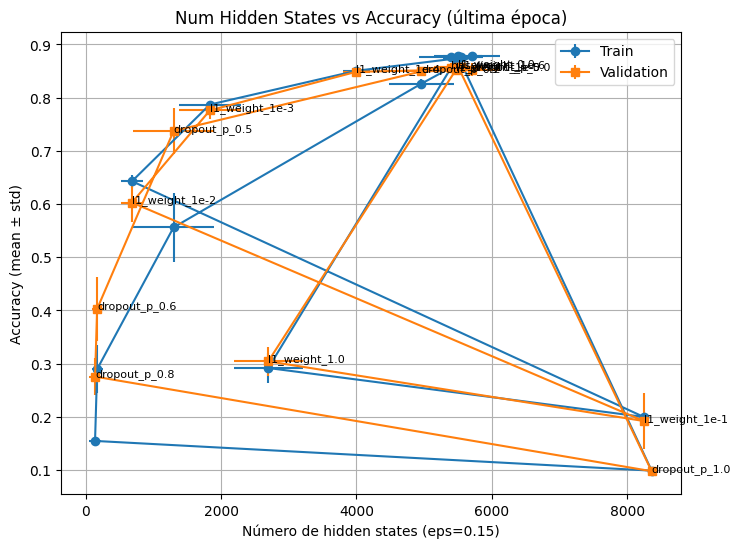

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from tqdm import tqdm  # <--- barra de progreso

# ===============================================
# CONFIG
# ===============================================
BASE_DIR = "runs/fashion_cv_dropout_l1"
EPS = 0.15  # tolerancia para considerar dos activaciones "iguales"

# ===============================================
# Función para contar unique states
# ===============================================
def count_unique_states(X, eps=EPS):
    Xn = normalize(X)  # normalizar L2
    reps = []
    for x in Xn:
        if not reps:
            reps.append(x)
            continue
        dists = np.linalg.norm(np.array(reps) - x, axis=1)
        if np.min(dists) > eps:
            reps.append(x)
    return len(reps)

# ===============================================
# Recolectar resultados
# ===============================================
results = []

param_dirs = sorted(glob.glob(os.path.join(BASE_DIR, "*")))

print(f"Procesando {len(param_dirs)} parámetros...")

for param_dir in tqdm(param_dirs, desc="Parámetros"):
    param_name = os.path.basename(param_dir)
    if not os.path.isdir(param_dir):
        continue

    fold_dirs = sorted(glob.glob(os.path.join(param_dir, "fold*")))
    print(f"  Procesando {len(fold_dirs)} folds para {param_name}...")

    for fold_dir in tqdm(fold_dirs, desc=f"  Folds {param_name}", leave=False):
        fold_name = os.path.basename(fold_dir)

        act_file = os.path.join(fold_dir, "activations_collected.csv")
        met_file = os.path.join(fold_dir, "metrics.csv")

        if not (os.path.exists(act_file) and os.path.exists(met_file)):
            print(f"    Archivos faltantes en {fold_name}, saltando...")
            continue

        # Leer activaciones
        X = pd.read_csv(act_file).values
        num_states = count_unique_states(X, eps=EPS)

        # Leer métricas (última época)
        metrics = pd.read_csv(met_file)
        last = metrics.iloc[-1]
        train_acc = last["train_acc"]
        val_acc   = last["val_acc"]

        results.append({
            "param": param_name,
            "fold": fold_name,
            "num_states": num_states,
            "train_acc": train_acc,
            "val_acc": val_acc
        })
        print(f"    {fold_name}: num_states={num_states}, train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

results_df = pd.DataFrame(results)
print("\nEjemplo de resultados recolectados:\n", results_df.head())

# ===============================================
# Agregar folds
# ===============================================
agg = results_df.groupby("param").agg({
    "num_states": ["mean", "std"],
    "train_acc": ["mean", "std"],
    "val_acc": ["mean", "std"]
}).reset_index()

agg.columns = ["param", "num_states_mean", "num_states_std",
               "train_acc_mean", "train_acc_std",
               "val_acc_mean", "val_acc_std"]

print("\nResultados agregados:\n", agg)

# ===============================================
# Plot num_states vs accuracy
# ===============================================
plt.figure(figsize=(8,6))

# Train curve
plt.errorbar(agg["num_states_mean"], agg["train_acc_mean"],
             xerr=agg["num_states_std"], yerr=agg["train_acc_std"],
             fmt="o-", label="Train")

# Val curve
plt.errorbar(agg["num_states_mean"], agg["val_acc_mean"],
             xerr=agg["num_states_std"], yerr=agg["val_acc_std"],
             fmt="s-", label="Validation")

for i, row in agg.iterrows():
    plt.text(row["num_states_mean"], row["val_acc_mean"], row["param"], fontsize=8)

plt.xlabel(f"Número de hidden states (eps={EPS})")
plt.ylabel("Accuracy (mean ± std)")
plt.title("Num Hidden States vs Accuracy (última época)")
plt.legend()
plt.grid(True)
plt.show()
